In [39]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [40]:
df = pd.read_csv('./data/text.csv')

In [41]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [42]:
class EmotionsDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx, 1]  # Первый столбец содержит текст
        label = self.data.iloc[idx, 2]  # Второй столбец содержит метку класса
        return text, label

In [43]:
dataset = EmotionsDataset(df)

In [44]:
# Создадим пустой словарь для хранения уникальных слов
word_to_idx = {}

# Итерируемся по всем текстам в датасете и добавляем слова в словарь
for text, _ in dataset:
    words = text.split()
    for word in words:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)

In [45]:
# Обновим функцию collate для преобразования текста в векторы числовых идентификаторов с использованием словаря
def collate(batch):
    texts, labels = zip(*batch)
    text_ids = [[word_to_idx[word] for word in text.split()] for text in texts]
    max_len = max(len(ids) for ids in text_ids)
    padded_batch = [ids + [0] * (max_len - len(ids)) for ids in text_ids]
    return torch.tensor(padded_batch, dtype=torch.long), torch.tensor(labels)

In [46]:

# Создадим DataLoader с нашей функцией collate_fn
dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate)


In [47]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])  
        return output


In [48]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])  
        return output

In [49]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])  
        return output

In [50]:
criterion = nn.CrossEntropyLoss()

In [59]:
# Определение функции обучения
def train_model(model, dataloader, optimizer, criterion, num_epochs=5):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}')
    print('Training finished')
    return losses

In [60]:
# Определение функции оценки модели
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.2f}')
    return accuracy

In [61]:
# Создаем пустой словарь для подсчета уникальных слов
word_counts = {}

# Перебираем тексты в датасете и считаем количество каждого слова
for text, _ in dataset:
    words = text.split()
    for word in words:
        if word not in word_counts:
            word_counts[word] = 1
        else:
            word_counts[word] += 1

# Сортируем слова по количеству встречаемости
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Определяем vocab_size как количество уникальных слов или ограничиваем его определенным размером
vocab_size = len(sorted_word_counts)  # Например, ограничим vocab_size до 10 000
print("Vocabulary size:", vocab_size)


Vocabulary size: 75302


In [66]:
embedding_dim = 100
hidden_size = 256
output_size = 6


In [67]:
rnn_model = RNNModel(vocab_size, embedding_dim, hidden_size, output_size)
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_size, output_size)
gru_model = GRUModel(vocab_size, embedding_dim, hidden_size, output_size)

In [68]:
rnn_optimizer = optim.Adam(rnn_model.parameters())
lstm_optimizer = optim.Adam(lstm_model.parameters())
gru_optimizer = optim.Adam(gru_model.parameters())

In [69]:
print("Training RNN...")
rnn_losses = train_model(rnn_model, dataloader, rnn_optimizer, criterion)

Training RNN...
Epoch 1/5, Loss: 20771.281811594963
Epoch 2/5, Loss: 20768.710453391075
Epoch 3/5, Loss: 20757.942029833794
Epoch 4/5, Loss: 20753.780945181847
Epoch 5/5, Loss: 20744.558104991913
Training finished


In [ ]:
for text, label in dataset:
    print(text)
    print(type(label))
    break

i just feel really helpless and heavy hearted
<class 'numpy.int64'>


In [70]:
print("Training LSTM...")
lstm_losses = train_model(lstm_model, dataloader, lstm_optimizer, criterion)

Training LSTM...
Epoch 1/5, Loss: 13710.715182099142
Epoch 2/5, Loss: 1285.905124922734
Epoch 3/5, Loss: 1174.918312136484
Epoch 4/5, Loss: 1123.0909544857568
Epoch 5/5, Loss: 1089.9941179524867
Training finished


In [71]:
print("Training GRU...")
gru_losses = train_model(gru_model, dataloader, gru_optimizer, criterion)


Training GRU...
Epoch 1/5, Loss: 2653.8852193573257
Epoch 2/5, Loss: 1217.720459312608
Epoch 3/5, Loss: 1159.4756678713748
Epoch 4/5, Loss: 1113.8229236790721
Epoch 5/5, Loss: 1077.6645892592496
Training finished


In [72]:
print("\nEvaluating RNN...")
rnn_accuracy = evaluate_model(rnn_model, dataloader)


Evaluating RNN...
Accuracy on test set: 0.34


In [73]:
print("\nEvaluating LSTM...")
lstm_accuracy = evaluate_model(lstm_model, dataloader)


Evaluating LSTM...
Accuracy on test set: 0.94


In [74]:
print("\nEvaluating GRU...")
gru_accuracy = evaluate_model(gru_model, dataloader)


Evaluating GRU...
Accuracy on test set: 0.94


In [75]:
# Построение графиков
def plot_losses(losses, title):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()


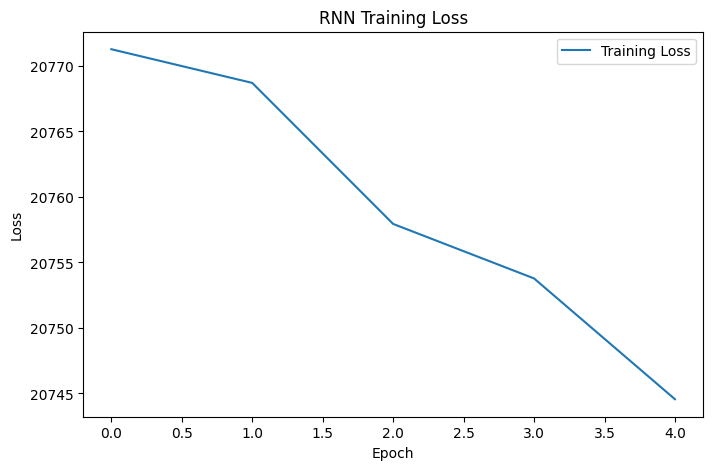

In [76]:
plot_losses(rnn_losses, 'RNN Training Loss')

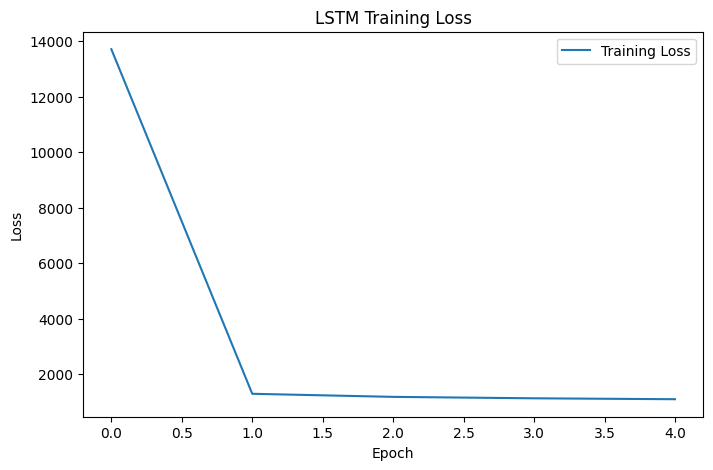

In [77]:
plot_losses(lstm_losses, 'LSTM Training Loss')


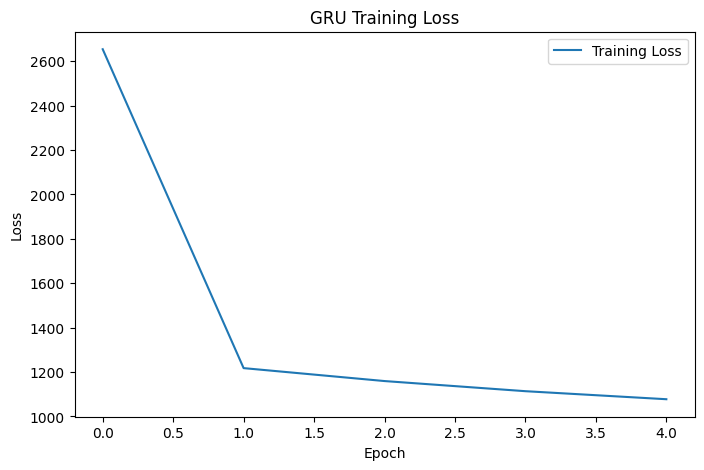

In [78]:
plot_losses(gru_losses, 'GRU Training Loss')


In [79]:
accuracies = {'RNN': rnn_accuracy, 'LSTM': lstm_accuracy, 'GRU': gru_accuracy}

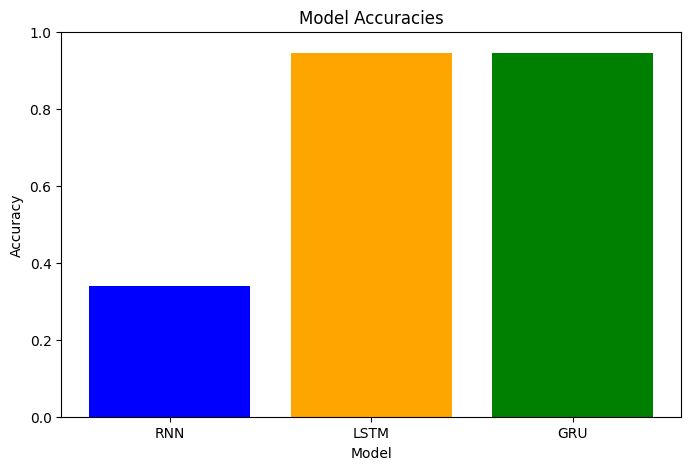

In [80]:
def plot_accuracies(accuracies):
    plt.figure(figsize=(8, 5))
    models = list(accuracies.keys())
    values = list(accuracies.values())
    plt.bar(models, values, color=['blue', 'orange', 'green'])
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracies')
    plt.ylim(0, 1)
    plt.show()

plot_accuracies(accuracies)